# Tooth and Cavity Instance Segmentation
Deep learning in dentistry holds a multitude of applications for identifying various dental conditions and diseases. Here, we train a deep-learning model for identifying and segmenting instances of the following:
- Caries
- Cavities
- Teeth
- Cracks

**Instance Segmentation** requires a model to not only create an image mask to classify objects pixel-by-pixel, but also to create boundaries to separate multiple instances of the same object. While multiple architectures are available for performing instance segmentation, we focus on training and comparing the following models:
- Mask RCNN
- YOLOv8

## Setup
Let's begin by importing necessary modules, set up some commonly used paths, and ingest our data. This data comes courtesy of Arab Academy on Roboflow:
- https://universe.roboflow.com/arab-academy-vf9su/dental-7yegp

In [1]:
import numpy as np
import cv2 as cv

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
torchvision.disable_beta_transforms_warning()

from torchvision import models, datasets
from torchvision.datasets import (
    CocoDetection,
    wrap_dataset_for_transforms_v2
)
from torchvision.transforms import v2

from types import SimpleNamespace
from pathlib import Path
from pprint import pprint
from typing import Optional, Tuple
from collections import defaultdict
from tqdm.cli import tqdm

2024-11-27 13:55:48.900537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 13:55:50.604129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append("../src/")

from mask_rcnn_model import MaskRCNNTrainer
from mask_rcnn_visualizations import plot_coco_image
from mask_rcnn_utils import (
    get_cocodetection_dataset,
    custom_collate_function,
    process_output,
    process_outputs,
    CATEGORY_ID_TO_NAME
)

In [3]:
%load_ext tensorboard

In [4]:
FPATHS = SimpleNamespace()
FPATHS.data = Path("../data/")

FPATHS.data_train = FPATHS.data / "train"
FPATHS.data_valid = FPATHS.data / "valid"
FPATHS.data_test = FPATHS.data / "test"

FPATHS.data_annotations_fname = "_annotations.coco.json"
FPATHS.data_train_annotations = FPATHS.data_train / FPATHS.data_annotations_fname
FPATHS.data_valid_annotations = FPATHS.data_valid / FPATHS.data_annotations_fname
FPATHS.data_test_annotations = FPATHS.data_test / FPATHS.data_annotations_fname

FPATHS.models = Path("../models/mask_rcnn/")
FPATHS.logs = Path("../logs/mask_rcnn")

In [5]:
MODEL_NAME = "maskrcnn_resnet50_fpn_v2"
MAX_EPOCHS = 50

# Memory constraints limits us to only 2 observations/batch (8GB VRAM)
BATCH_SIZE = 2

# (<inf For Testing purposes) - only run these number of batches in training dataset
MAX_BATCHES_TRAIN = np.inf
MAX_BATCHES_VALID = np.inf
# MAX_BATCHES_TRAIN = 16
# MAX_BATCHES_VALID = MAX_BATCHES_TRAIN // 3

LEARNING_RATE = 1e-3
EARLY_STOP_PATIENCE = 5

# Learning rate schedule parameters (Reduce LR on Plateau)
LR_SCHEDULER_FACTOR = 0.1
LR_SCHEDULER_PATIENCE = 3

# How many batches to run through before logging our metrics
LOG_BATCH_INTERVAL = 128
LOG_VALID_IMAGES = BATCH_SIZE

assert LOG_VALID_IMAGES <= BATCH_SIZE and LOG_VALID_IMAGES >= 0, (
    "LOG_VALID_IMAGES must be non-negative and not larger than BATCH_SIZE"
)


print(f"""
Model Training 
- Model:                   {MODEL_NAME}
- Initial Learning Rate:   {LEARNING_RATE}
- Max Epochs:              {MAX_EPOCHS}
- Ealy Stop Patience:      {EARLY_STOP_PATIENCE}

Data Loading
- Batch Size:              {BATCH_SIZE}
- Maximum Batches (Train): {MAX_BATCHES_TRAIN}
- Maximum Batches (Valid): {MAX_BATCHES_VALID}

Logging
- Log Batch Interval:      {LOG_BATCH_INTERVAL} (Based on Effective Batch Size)
- Log Validation Images:   {LOG_VALID_IMAGES} (# Of Validation Images to Display)
""")


Model Training 
- Model:                   maskrcnn_resnet50_fpn_v2
- Initial Learning Rate:   0.001
- Max Epochs:              50
- Ealy Stop Patience:      5

Data Loading
- Batch Size:              2
- Maximum Batches (Train): inf
- Maximum Batches (Valid): inf

Logging
- Log Batch Interval:      128 (Based on Effective Batch Size)
- Log Validation Images:   2 (# Of Validation Images to Display)



### Defining Augmentations and Train/Val/Test Datasets
Since data provides bounding boxes, masks, and segmentations in the [COCO format](https://cocodataset.org/#home), we can utilize `torchvision.datasets.CocoDetection` class to help load the data in as a PyTorch Dataset.

We also define the augmentations to integrate with our training observations.

In [6]:
datasets = SimpleNamespace()
datasets.train = get_cocodetection_dataset(FPATHS.data_train, FPATHS.data_train_annotations, True)
datasets.valid = get_cocodetection_dataset(FPATHS.data_valid, FPATHS.data_valid_annotations, False)
datasets.test = get_cocodetection_dataset(FPATHS.data_test, FPATHS.data_test_annotations, False)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Visualizing Instances
Let's build out some functionality to visualize the bounding boxes, masks, and segmentations of each observation. We define `plot_coco_image()` for this purpose.

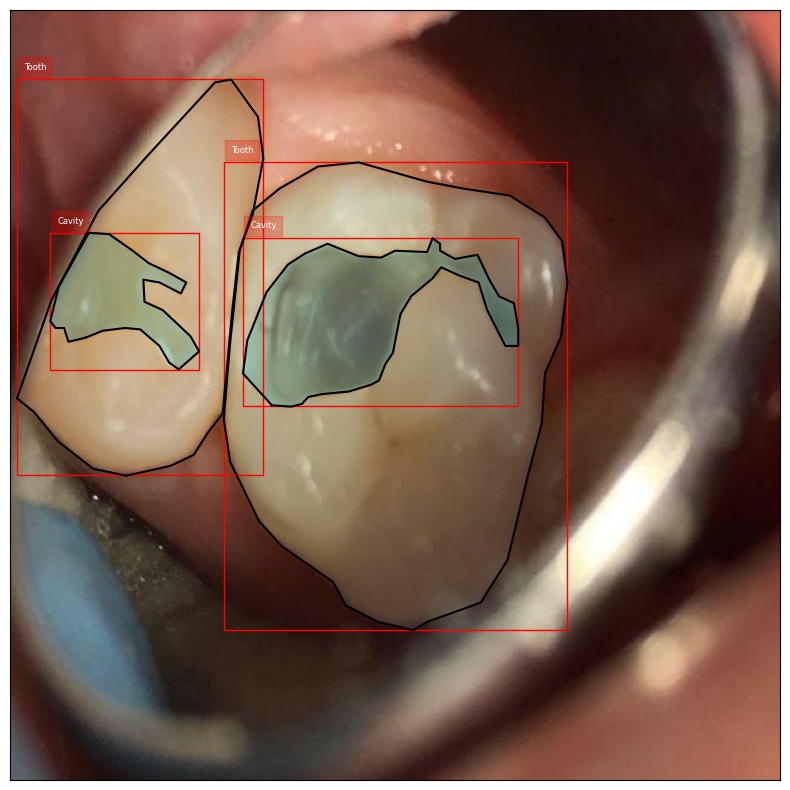

In [7]:
image, target = datasets.train[1]
coco_image_example = plot_coco_image(
    image,
    target,
    plot_masks=True,
    plot_bboxes=True,
    plot_segmentations=True,
    plot_category_id=True,
    category_names=CATEGORY_ID_TO_NAME,
)

### Creating a PyTorch `DataLoader`
Dataloader's help us retrieve a batch of training samples for more seamless model training training. Since PyTorch expects each batch to be constant, we have to update our `collate_fn`. We define `custom_collate_function()` to represent each batch as a tuple `(images, targets)`. To ensure we can run the network on our GPU, we also have to move the images and certain targets to the GPU.

Here, we can the structure of each batch:

```python
# Start iterating through the dataloader
images, targets = next(iter(dataloader))

# Extracts the first instance in the batch
image = images[0]
target = targets[0]

# Access the data in the target
target_bboxes = target["bbox"]
target_areas = target["area"]
target_segmentation = target["segmentation"]
```

In [8]:
dataloaders = SimpleNamespace()
dataloaders.train = DataLoader(
    datasets.train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_function
)

dataloaders.valid = DataLoader(
    datasets.valid,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_function
)

dataloaders.test = DataLoader(
    datasets.test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_function
)

## Model - Mask RCNN

For instance segmentation, PyTorch provides [Mask R-CNN](https://pytorch.org/vision/0.9/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).


In [9]:
# Set to `True` if we want to train the model;
# Otherwise skip and use previously-stored model checkpoints
train_model = False

if train_model:
    mask_rcnn = models.get_model(
        MODEL_NAME,
        weights=None,
        weights_backbone=None
    )
    
    mask_rcnn.cuda()
    
    mask_rcnn_trainer = MaskRCNNTrainer(
        mask_rcnn,
        dataloaders.train,
        dataloaders.valid,
        learning_rate=LEARNING_RATE,
        scheduler_factor=LR_SCHEDULER_FACTOR,
        scheduler_patience=LR_SCHEDULER_PATIENCE,
        early_stop_patience=EARLY_STOP_PATIENCE,
        log_batches_interval=LOG_BATCH_INTERVAL,
        fpath_logs=FPATHS.logs,
        fpath_models=FPATHS.models,
        max_batches_train=MAX_BATCHES_TRAIN,
        max_batches_valid=MAX_BATCHES_VALID
    )
    
    mask_rcnn_trainer.train(MAX_EPOCHS)

## Explore Model Checkpoints

In [10]:
# Use the best model checkpoint (defined by the model with the lowest valid_loss)
FPATHS.model_checkpoints = FPATHS.models.glob("*.pth")
checkpoint = min(
    (torch.load(checkpoint) for checkpoint in FPATHS.model_checkpoints),
    key=lambda chkpt: chkpt["valid_loss"]
)

# Load the model state dict
model = models.get_model(MODEL_NAME, weights=None, weights_backbone=None)
model.load_state_dict(checkpoint["model_state_dict"])
model.cuda()
model.eval()

# Load the optimizer state dict - MaskRCNNTrainer uses Adam
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Load the scheduler state dict - MaskRCNNTrainer uses ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer)
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

In [11]:
# Generate some predictions with the testing data
images, targets = next(iter(dataloaders.test))
with torch.no_grad():
    outputs = model(images, targets)

outputs = process_outputs(outputs, iou_threshold=0.01)

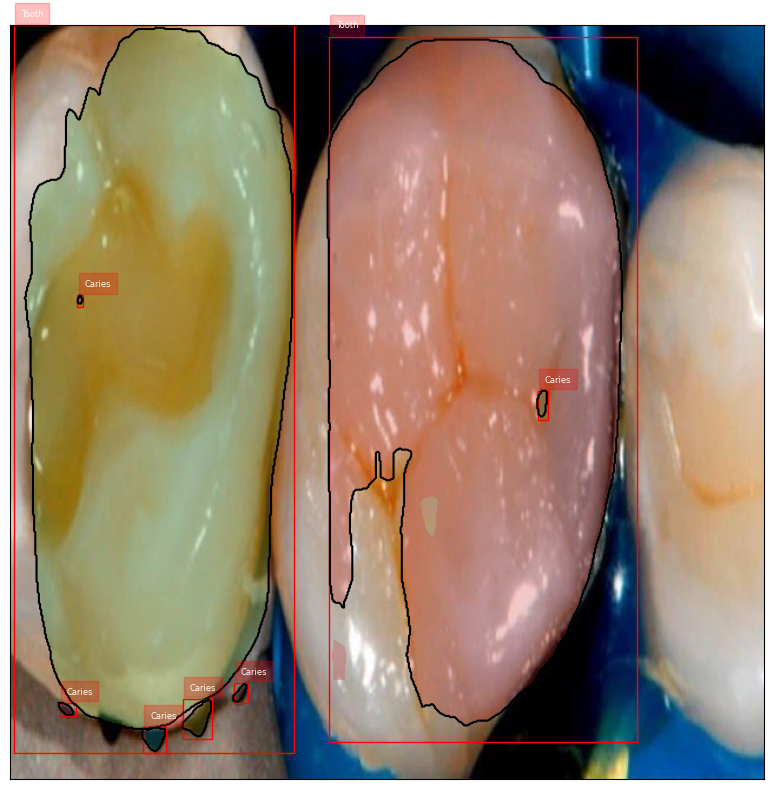

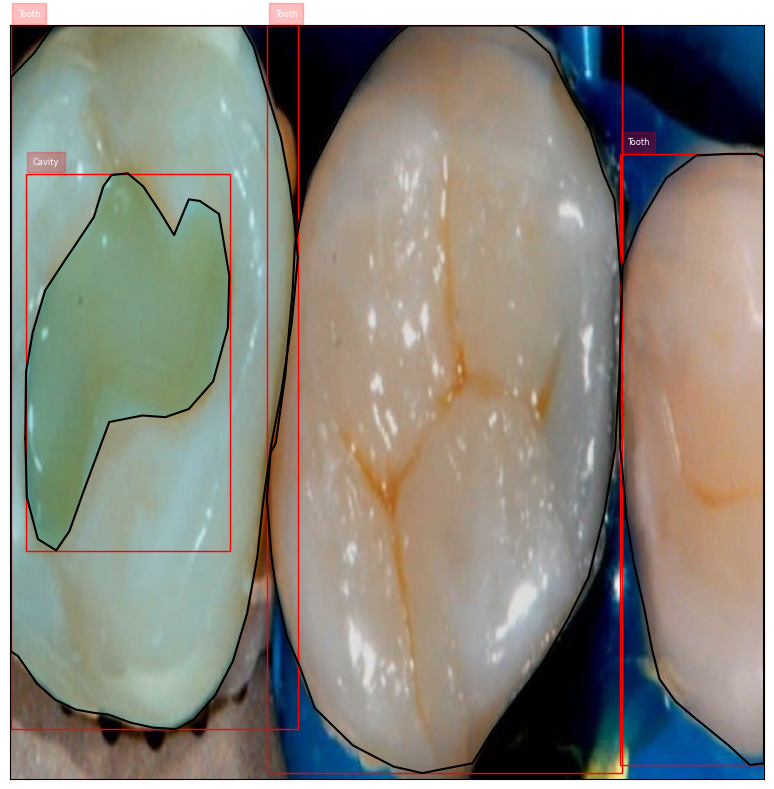

In [12]:
i = 0
image_pred = plot_coco_image(
    images[i].cpu(),
    outputs[i],
    category_names=CATEGORY_ID_TO_NAME,
    plot_masks=True,
    plot_bboxes=True,
    plot_segmentations=True
)

image_true = plot_coco_image(
    datasets.test[i][0],
    datasets.test[i][1],
    category_names=CATEGORY_ID_TO_NAME
)